# GW parameter estimation with PTMCMC

We use the IMRPhenomD $h_{22}$ waveform model to simulate (noise-free) data and recover the parameters via parallel tempering MCMC. The noise weighted inner product uses the aLIGO theoretical noise PSD. All inner products, likelihood evaluations, etc. are conducted in the frequency-domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner
from scipy.stats import multivariate_normal

import wave_gen as wg
import data as d
import likelihood as l
import jumps as j
from PTMCMC import PTMCMC


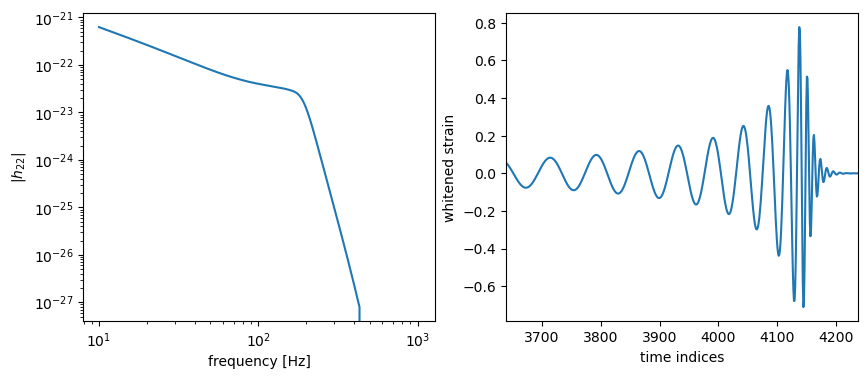

In [2]:
# plot injected waveform (data) in frequency- and time-domain

# frequency-domain
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.loglog(wg.f, d.data_amp)
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$|h_{22}|$')

# time-domain
plt.subplot(1, 2, 2)
# pad lower frequencies for iFFT
npad = int(wg.f[0] / wg.df)
whitened_FD_waveform = np.pad(d.data_FD_waveform / l.sqrtS, (npad, 0))
TD_waveform = np.fft.irfft(whitened_FD_waveform)
TD_waveform = np.roll(TD_waveform, TD_waveform.shape[0] // 2)
plt.plot(TD_waveform)
plt.xlim(np.argmax(TD_waveform) - 500, np.argmax(TD_waveform) + 100)
plt.xlabel('time indices')
plt.ylabel('whitened strain')
plt.show()

In [3]:
# jump proposals
Fisher = j.Fisher(d.x_inj)
diff_evol = j.DifferentialEvolution(len_history=100)
jump_proposals = [[Fisher.vectorized_Fisher_jump, 20],
                  [diff_evol.vectorized_DE_jump, 20]]

# do PTMCMC!
num_samples = int(1e5)
num_chains = 15
samples, lnposts, temp_ladder = PTMCMC(num_samples=num_samples,
                                       num_chains=num_chains,
                                       x0=d.x_inj,
                                       ln_posterior_func=l.ln_posterior,
                                       jump_proposals=jump_proposals,
                                       PT_swap_weight=10)

Final spin (Mf=-0.758876) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.753981) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.755511) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.759361) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.735573) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.740131) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.734452) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.719475) and ISCO frequency of this system are small, the model might misbehave here.
Final spin (Mf=-0.762217) and ISCO frequency of this system are small, the model might misbehave here.
Jump acceptance rates
Fisher_jump: [0.69006142 0.68306314 0.68117511 0.67

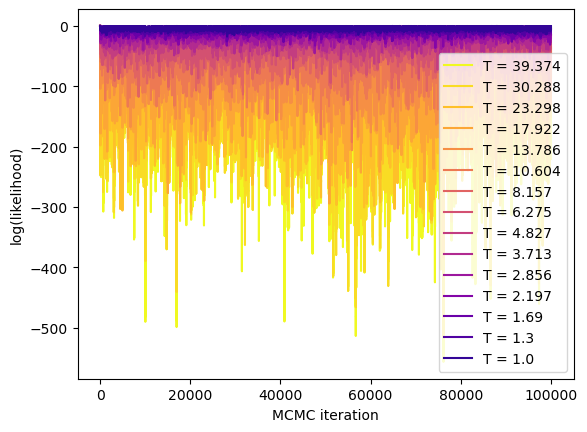

In [4]:
# plot likelihood values of chains (without temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(lnposts[::-1][j] * temp, color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend(loc='lower right')
plt.show()

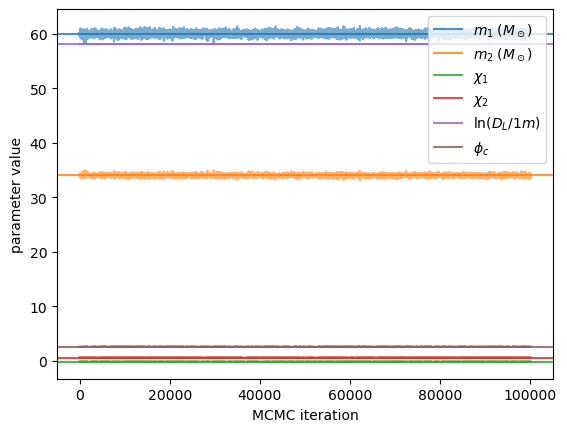

In [5]:
# trace plot for T = 1 chain
for i in range(wg.ndim):
    plt.plot(samples[0,:,i], color=f'C{i}', alpha=0.6)
    plt.axhline(d.x_inj[i], color=f'C{i}', alpha=0.8, label=wg.x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show()

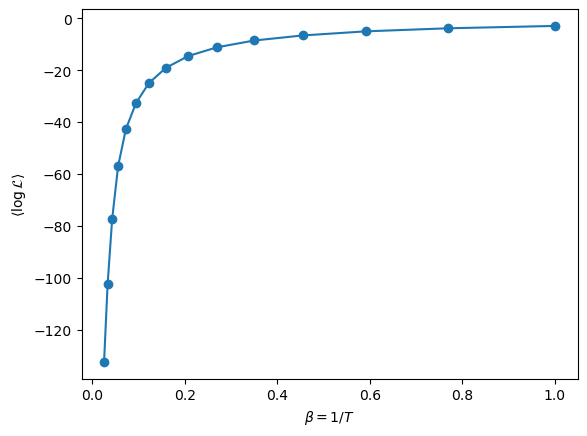

In [6]:
# average log-likelood over temperatures
burnin = num_samples // 5
avg_lnlikes = np.mean(lnposts[:, burnin:], axis=1) * temp_ladder
betas = 1. / temp_ladder
plt.plot(betas, avg_lnlikes, marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle\log\mathcal{L}\rangle$')
plt.show()

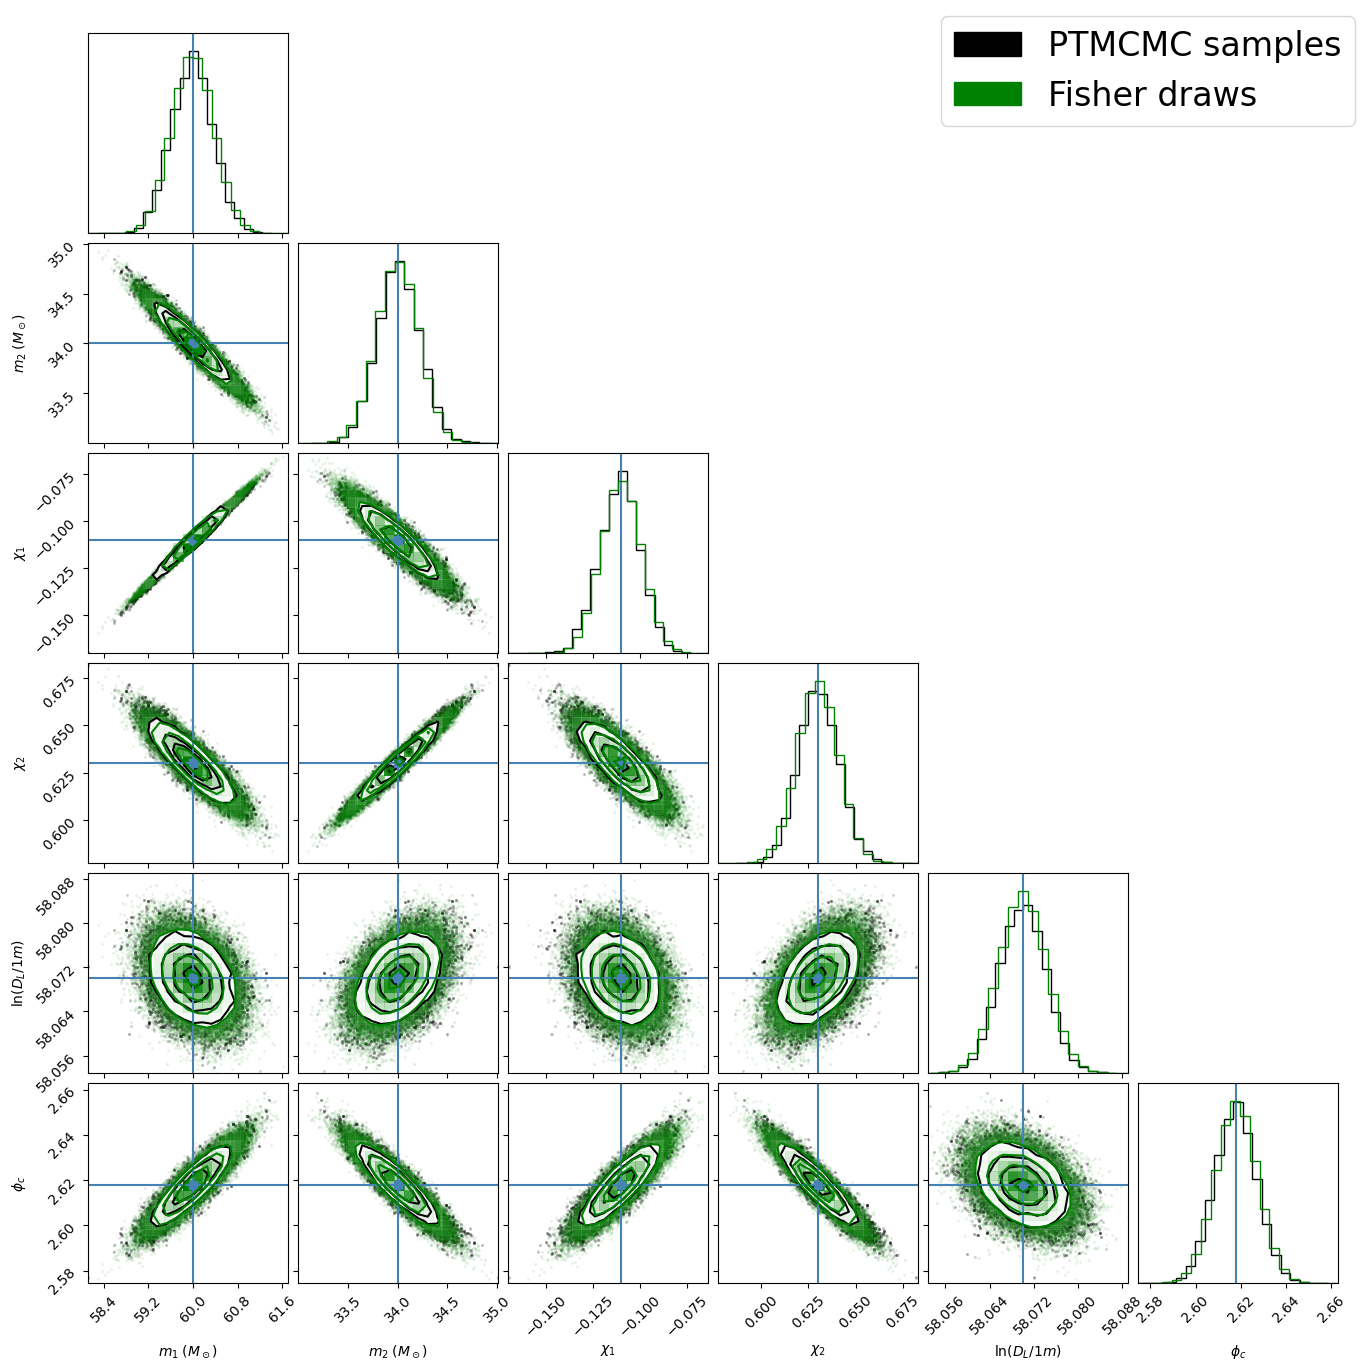

In [7]:
# corner plot
fig = corner(samples[0, burnin:],
             truths=d.x_inj,
             labels=wg.x_labels)

# also plot samples from multi-variate Gaussian
# which has a covariance estimated from the inverse Fisher
Fisher_samples = multivariate_normal(d.x_inj, np.linalg.inv(l.get_Fisher(d.x_inj))).rvs(num_samples - burnin)
corner(Fisher_samples, color='green', fig=fig)

black_patch = mpatches.Patch(color='black', label='PTMCMC samples')
green_patch = mpatches.Patch(color='green', label='Fisher draws')
handles, labels = plt.gca().get_legend_handles_labels()
handles += [black_patch, green_patch]
fig.legend(handles=handles, loc='upper right', fontsize=24)
plt.show()

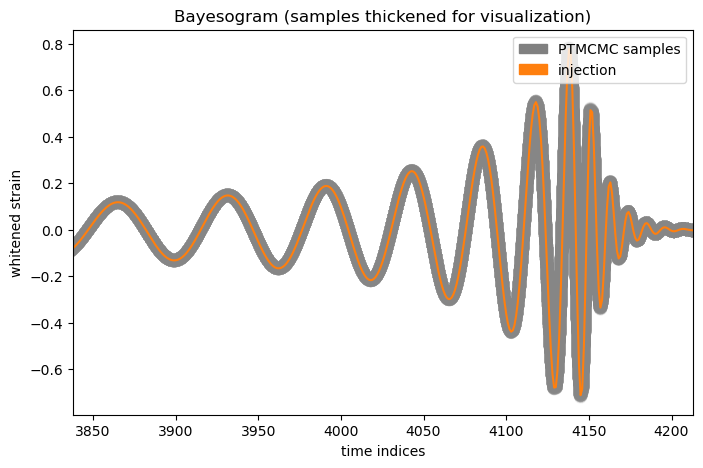

In [8]:
npad = int(wg.f[0] / wg.df)
whitened_FD_waveform_inj = np.pad(d.data_FD_waveform / l.sqrtS, (npad, 0))
TD_waveform_inj = np.fft.irfft(whitened_FD_waveform_inj)
roll_amt = TD_waveform_inj.shape[0] // 2
TD_waveform_inj = np.roll(TD_waveform_inj, roll_amt)

num_draws = 100
draw_ndxs = np.random.choice(np.arange(burnin, num_samples), num_draws)
plt.figure(figsize=(8, 5))
for ndx in draw_ndxs:
    whitened_FD_waveform = np.pad(wg.FD_waveform(samples[0, ndx]) / l.sqrtS, (npad, 0))
    TD_waveform = np.fft.irfft(whitened_FD_waveform)
    TD_waveform = np.roll(TD_waveform, roll_amt)
    plt.plot(TD_waveform, color='grey', alpha=1.0/num_draws, lw=10)
plt.plot(TD_waveform_inj, color='C1')
grey_patch = mpatches.Patch(color='grey', label='PTMCMC samples')
orange_patch = mpatches.Patch(color='C1', label='injection')
handles, labels = plt.gca().get_legend_handles_labels()
handles += [grey_patch, orange_patch]
plt.legend(handles=handles, loc='upper right')
plt.xlim(np.argmax(TD_waveform) - 300, np.argmax(TD_waveform) + 75)
plt.xlabel('time indices')
plt.ylabel('whitened strain')
plt.title('Bayesogram (samples thickened for visualization)')
plt.show()